In [1]:
import pandas as pd
import numpy as np
import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import ml_metrics as metrics

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
ratings = pd.read_csv('ml-latest/ratings.csv')
ratings = ratings.query('rating >=1')
ratings.reset_index(drop=True, inplace=True)

In [3]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')
print(ratings.shape)
ratings.head(3)

(2998092, 4)


,userId,movieId,rating,timestamp
1240,17,1,5.0,944991567
1241,17,2,3.0,944991114
1242,17,3,2.0,944993651


In [5]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('ml-latest/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

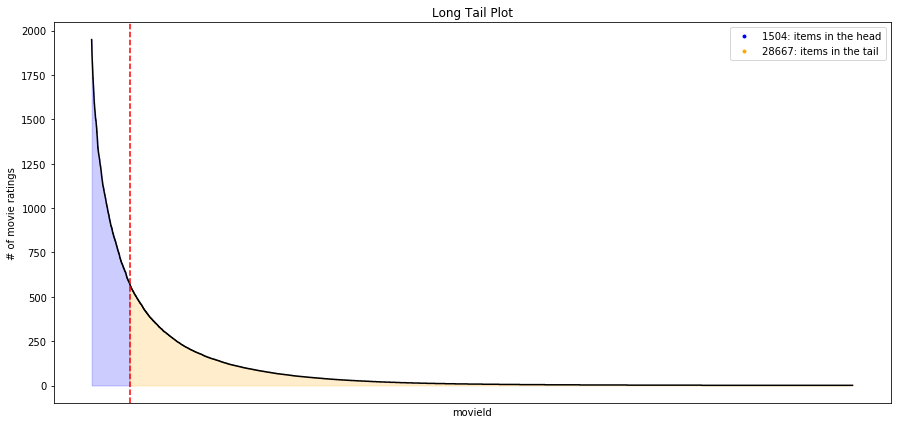

In [6]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [7]:
#format data for surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.20)

In [8]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [10]:
#make predictions on test set. 
test = algo.test(testset)
test=pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,220283,1267,4.0,4.899718
1,227157,1541,2.5,2.450923
2,192880,204,3.0,2.846574
3,46039,3893,1.0,3.092805
4,158530,5745,1.0,3.061126


In [11]:
#evaluate model with MSE and RMSE
print("MSE for Collaborative Recommendatio: ",recmetrics.mse(test.actual, test.cf_predictions))
print("RMSE for Collaborative Recommendatio: ",recmetrics.rmse(test.actual, test.cf_predictions))

MSE for Collaborative Recommendatio:  0.4937193389488371
RMSE for Collaborative Recommendatio:  0.7026516483641357


In [14]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [15]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [16]:
#format test data
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
#make recommendations for all members in the test data
cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 5, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

/Users/mousumiakter/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


,actual,cf_predictions
userId,,
17,"[512, 1, 1018, 1027, 516, 1029, 2054, 1544, 20...","[1198, 1, 260, 1022, 2096]"
373,"[5636, 3588, 2566, 6149, 40966, 11, 525, 6158,...","[953, 1252, 3134, 1219, 1248]"
670,"[3, 4612, 6660, 1542, 6, 4616, 1544, 10, 6662,...","[318, 1198, 3996, 2692, 1203]"
707,"[509, 49666, 112138, 2571, 1036, 527, 18, 6095...","[4973, 1203, 2571, 527, 2762]"
768,"[26629, 1544, 3081, 4105, 2571, 6156, 41997, 5...","[6016, 2571, 527, 1178, 1089]"


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [17]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(5).index.tolist()

pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
17,"[512, 1, 1018, 1027, 516, 1029, 2054, 1544, 20...","[1198, 1, 260, 1022, 2096]","[2571, 1270, 480, 593, 296]"
373,"[5636, 3588, 2566, 6149, 40966, 11, 525, 6158,...","[953, 1252, 3134, 1219, 1248]","[2571, 1270, 480, 593, 296]"
670,"[3, 4612, 6660, 1542, 6, 4616, 1544, 10, 6662,...","[318, 1198, 3996, 2692, 1203]","[2571, 1270, 480, 593, 296]"
707,"[509, 49666, 112138, 2571, 1036, 527, 18, 6095...","[4973, 1203, 2571, 527, 2762]","[2571, 1270, 480, 593, 296]"
768,"[26629, 1544, 3081, 4105, 2571, 6156, 41997, 5...","[6016, 2571, 527, 1178, 1089]","[2571, 1270, 480, 593, 296]"


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [18]:
#make recommendations for all members in the test data

ran_recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(5).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
17,"[512, 1, 1018, 1027, 516, 1029, 2054, 1544, 20...","[1198, 1, 260, 1022, 2096]","[2571, 1270, 480, 593, 296]","[67087, 6193, 58047, 2618, 1876]"
373,"[5636, 3588, 2566, 6149, 40966, 11, 525, 6158,...","[953, 1252, 3134, 1219, 1248]","[2571, 1270, 480, 593, 296]","[2906, 145, 2134, 8784, 4474]"
670,"[3, 4612, 6660, 1542, 6, 4616, 1544, 10, 6662,...","[318, 1198, 3996, 2692, 1203]","[2571, 1270, 480, 593, 296]","[7228, 52, 31427, 5772, 2004]"
707,"[509, 49666, 112138, 2571, 1036, 527, 18, 6095...","[4973, 1203, 2571, 527, 2762]","[2571, 1270, 480, 593, 296]","[44191, 991, 1211, 364, 67408]"
768,"[26629, 1544, 3081, 4105, 2571, 6156, 41997, 5...","[6016, 2571, 527, 1178, 1089]","[2571, 1270, 480, 593, 296]","[1356, 2617, 36517, 3763, 1965]"


# Recall

In [ ]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [ ]:
pop_mark = []
for K in np.arange(1, 6):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
print(pop_mark)

In [ ]:
random_mark = []
for K in np.arange(1, 6):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
print(random_mark)

In [ ]:
cf_mark = []
for K in np.arange(1, 6):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
print(cf_mark)

# Mark Plot

In [ ]:
mark_scores = [pop_mark, cf_mark]
index = range(1,5+1)
names = ['Rank-based Recommendation', 'Collaborative Recommendation']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

# Precision

In [ ]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [ ]:
pop_mapk = []
for K in np.arange(1,6):
    pop_mapk.extend([metrics.mapk(actual, pop_predictions, k=K)])
print(pop_mapk)

In [ ]:
random_mapk = []
for K in np.arange(1, 6):
    random_mapk.extend([metrics.mapk(actual, random_predictions, k=K)])
print(random_mapk)

In [ ]:
cf_mapk = []
for K in np.arange(1,9):
    cf_mapk.extend([metrics.mapk(actual, cf_predictions, k=K)])
print(cf_mapk)

# MapK Plot

In [ ]:
plt.figure(figsize=(15,7))
plt.suptitle('Mean Average Precision (MAP@K) at K Comparison')

plt.xlabel('K')
plt.ylabel('MAP@K')

K=['1','2','3','4','5']

plt.plot(K,pop_mapk, 'r')
plt.plot(K,cf_mapk,'b')

plt.legend(['Rank-based Recommendation', 'Collaborative Recommendation'], loc='upper left')

plt.show()

# Personalization

In [ ]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [ ]:
recmetrics.personalization(predicted=example_predictions)

# Intra-list Similarity

In [ ]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [ ]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [ ]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

# Precision Recall Curve

In [ ]:
recmetrics.precision_recall_plot(targs=actual, preds=model_probs)